#Set up  
Download and import all necessary libraries


In [ ]:
!export CUDA_VISIBLE_DEVICES=1
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["FLASH_ATTENTION_2_ENABLED"] = "0"
os.environ["TRANSFORMERS_NO_FLASH_ATTN"] = "1"
import glob
import re
import numpy as np
import torch
import gc
import cv2
from PIL import Image
import av
import imageio
from videollama2 import model_init, mm_infer
from videollama2.utils import disable_torch_init
from sentence_transformers import SentenceTransformer, util
import logging
import time
import pandas as pd
import json
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import traceback
import string
from typing import List, Optional, Tuple
from collections import defaultdict
import nltk
nltk.download('punkt')
from transformers import CLIPImageProcessor


##### Configuration 
-Sets up logging
-inputs and outputs paths  
-models ID and parameters

Configure utilities function for prompting  
Configure evaluation function  
Configure visualisation of attention maps


In [ ]:
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Configuration
original_video_dir = "/home/kassandralea.briola/Project/VideoCheck"
mask_dir_base = "/home/kassandralea.briola/Project/output/masks"
model_id = "DAMO-NLP-SG/VideoLLaMA2-7B"
target_size = 224
patch_size = 16
max_frames = 24

GROUND_TRUTH_PATH = "/home/kassandralea.briola/Project/GroundTruth/ground_truth_answer.json"
OUTPUT_DIR = "/home/kassandralea.briola/Project/output"
DETAILED_TABLE_PATH = os.path.join(OUTPUT_DIR, "detailed_evaluation_table.csv")
SUMMARY_TABLE_PATH = os.path.join(OUTPUT_DIR, "summary_accuracy_table.csv")
PROMPTS_JSON_PATH = '/home/kassandralea.briola/Project/GroundTruth/prompts.json'


# Load ground truth answers
try:
    with open(GROUND_TRUTH_PATH, 'r') as f:
        ground_truth = json.load(f)
except FileNotFoundError:
    logger.error(f"Ground truth file not found at {GROUND_TRUTH_PATH}")
    ground_truth = {}

# --- Prompt Configuration ---
def load_prompts_from_file():
    try:
        with open(PROMPTS_JSON_PATH, 'r') as f:
            prompts = json.load(f)
        print(f"Loaded {len(prompts)} prompts from {PROMPTS_JSON_PATH}")
        return prompts
    except Exception as e:
        print(f"Error loading prompts.json: {e}")
        return {}

def clean_text(text):
    return text.lower().translate(str.maketrans('', '', string.punctuation)).strip()

def split_questions(prompt_text):
    # splits questions by numbers at the start of each question
    questions = re.split(r'\d+\.\s*', prompt_text)
    # Remove any empty strings
    questions = [q.strip() for q in questions if q.strip()]
    if len(questions) > 1 and not any(word in questions[0].lower() for word in ["?", "what", "how", "why", "list"]):
        questions = questions[1:]
    return questions

def categorize_question(question_text):
    question_text = question_text.lower().strip()
    open_ended_keywords = [
        "why", "describe", "explain", "reason", "cause", "effect", "list"
    ]
    # Remove punctuation for matching
    question_text_clean = re.sub(r'[^\w\s]', '', question_text)
    words = question_text_clean.split()
    if words and words[0] in open_ended_keywords:
        return "open-ended"
    for keyword in open_ended_keywords:
        if keyword in question_text_clean:
            return "open-ended"
    return "categorical"

# --- Visualization Utility ---
def save_attention_overlay(frame, attn_map, save_path, title=None, cmap='jet', alpha=0.5):
    plt.figure(figsize=(6, 6))
    if isinstance(frame, Image.Image):
        frame_np = np.array(frame)
    else:
        frame_np = frame
    plt.imshow(frame_np)
    if attn_map is not None:
        plt.imshow(attn_map, cmap=cmap, alpha=alpha)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

def visualize_attention_for_mode(video_name, mode, frames, masks=None, output_base="attention_maps"):
    mode_dir = os.path.join(output_base, video_name, mode)
    os.makedirs(mode_dir, exist_ok=True)
    logger.debug(f"Visualizing attention for {video_name} in mode {mode}, {len(frames)} frames")
    for idx, frame in enumerate(frames):
        try:
            logger.debug(f"Processing frame {idx}, frame type: {type(frame)}")
            if mode == "original":
                attn_map = np.ones(frame.size[::-1]) if isinstance(frame, Image.Image) else np.ones(frame.shape[:2])
            elif mode == "crop-and-mask":
                mask = masks[idx] if masks and idx < len(masks) else None
                attn_map = mask if mask is not None else np.zeros(frame.size[::-1] if isinstance(frame, Image.Image) else frame.shape[:2])
            else:
                logger.warning(f"Unsupported mode {mode} for visualization")
                continue
            save_path = os.path.join(mode_dir, f"frame_{idx:03d}.png")
            save_attention_overlay(frame, attn_map, save_path, title=f"{mode} - frame {idx}")
        except Exception as e:
            logger.error(f"Failed to visualize frame {idx} for {video_name} in mode {mode}: {str(e)}")
            continue

# --- Evaluation Functions ---
def evaluate_responses(video_id, model_answers, ground_truth, prompt, st_model):
    if video_id not in ground_truth or not model_answers:
        logger.warning(f"No ground truth for video {video_id} or no model answers provided")
        return {}

    gt_answers = ground_truth[video_id]
    results = {}
    for q_key in gt_answers:
        question_text = prompt.get(q_key, "")
        model_ans = model_answers.get(q_key, "")
        gt_info = gt_answers[q_key]
        # Support both old and new JSON formats
        if isinstance(gt_info, dict):
            gt_ans = gt_info.get("answer", "")
            keywords = gt_info.get("keywords", [])
        else:
            gt_ans = gt_info
            keywords = []
        category = categorize_question(question_text)

        metrics = {"category": category}

        if category == "categorical":
            model_ans_lower = model_ans.lower()
            pred_label = None
            for kw in keywords:
                if kw.lower() in model_ans_lower:
                    pred_label = kw.lower()
                    break
            # Compute semantic similarity for categorical as well
            try:
                emb_model = st_model.encode([model_ans.strip(), gt_ans.strip()])
                sim_score = util.cos_sim(emb_model[0], emb_model[1]).item()
            except Exception:
                sim_score = 0.0
            # Accept if keyword match OR semantic similarity is high
            metrics["keyword_accuracy"] = int((pred_label is not None) or (sim_score > 0.8))
            metrics["semantic_similarity"] = sim_score
            metrics["predicted_label"] = pred_label
            metrics["ground_truth_label"] = gt_ans.lower().strip()
        else:
            # Only semantic similarity for open-ended
            try:
                emb_model = st_model.encode([model_ans.strip(), gt_ans.strip()])
                metrics["semantic_similarity"] = util.cos_sim(emb_model[0], emb_model[1]).item()
            except Exception:
                metrics["semantic_similarity"] = 0.0
            metrics["keyword_accuracy"] = None
            metrics["predicted_label"] = None
            metrics["ground_truth_label"] = None
        results[q_key] = {
            "question": question_text,
            "ground_truth": gt_ans,
            "model_answer": model_ans,
            **metrics
        }
    return results

# Class Definition
Initializes Video-llama2-7b


In [ ]:
class ModelLoader:
    _instance = None

    def __new__(cls):
        if cls._instance is None:
            cls._instance = super().__new__(cls)
            cls._instance.load_models()
        return cls._instance

    def load_models(self):
        torch.cuda.empty_cache()
        gc.collect()
        try:
            disable_torch_init()
            logger.info("Loading Video-LLaMA2 model...")
            model_path = "DAMO-NLP-SG/VideoLLaMA2-7B"
            model, processor, tokenizer = model_init(model_path, use_flash_attn=False)
            if hasattr(model.config, "attn_implementation"):
                model.config.attn_implementation = "eager"
            if hasattr(model.config, "_attn_implementation"):
                model.config._attn_implementation = "eager"
            self.model = model
            self.processor = processor
            self.tokenizer = tokenizer
            logger.info("Loading SentenceTransformer model...")
            self.st_model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')
            logger.info("All models loaded successfully")
        except Exception as e:
            logger.error(f"Model loading failed: {e}")
            raise

##### Loads / process / Runs / evaluate
-loads LLAVa model / processor / sentence transformers model    
-select frames by indices    
-Compute motion intensity    
-Extract frames  
-loads and combines masks    
-preprocess frames, crops and masks them for crop-and-mask mode(selective attention method)  
-clean model responses  
-prepare videos and prompts inputs  
-runs the model to generate answers, track inference time and memory usage  
-reads video frames, applies masks, preprocesses frames return input data  
-Analyse the video: process / infer / save results




In [ ]:
def extract_clip_attention_per_frame(vision_model, processor, frames, device="cuda:0"):
    """
    Extracts attention maps from CLIPVisionModel for each frame.
    Returns a list of (num_layers, num_heads, seq_len, seq_len) tensors.
    """
    attn_per_frame = []
    vision_model = vision_model.to(device)
    vision_model.eval()

    # The processor from VideoLLaMA2 is a dict; the image processor is under the 'video' key.
    video_processor = processor

    for frame in frames:
        if isinstance(frame, Image.Image):
            img = frame
        else:
            img = Image.fromarray(frame)
        
        # Use the correct video_processor which is configured for the model (e.g., 336x336 size)
        inputs = video_processor(images=img, return_tensors="pt").to(device)
        
        with torch.no_grad():
            outputs = vision_model(
                pixel_values=inputs["pixel_values"],
                output_attentions=True,
                return_dict=True
            )
        # outputs.attentions: tuple of (num_layers, batch, num_heads, seq_len, seq_len)
        # Remove batch dim
        attn_stack = torch.stack([a[0].cpu() for a in outputs.attentions])  # (num_layers, num_heads, seq_len, seq_len)
        attn_per_frame.append(attn_stack)
    return attn_per_frame

def plot_layer_vs_frame_attention(attn_per_frame, save_path=None):
    """
    Plots a heatmap with y-axis as layers and x-axis as frames.
    Each cell shows the mean attention (over heads and tokens) for that layer and frame.
    """
    if attn_per_frame and attn_per_frame[0] is not None:
        layer_frame_matrix = []
        for attn_stack in attn_per_frame:
            # attn_stack: (num_layers, num_heads, seq_len, seq_len)
            # Take mean over heads and all tokens except [CLS] (token 0)
            mean_per_layer = attn_stack[:, :, 1:, 1:].mean(dim=(1,2,3)).cpu().numpy()
            layer_frame_matrix.append(mean_per_layer)
        layer_frame_matrix = np.stack(layer_frame_matrix, axis=0).T  # shape: (num_layers, num_frames)
        # Normalize the entire matrix
        min_val = np.nanmin(layer_frame_matrix)
        max_val = np.nanmax(layer_frame_matrix)
        if max_val > min_val:
            layer_frame_matrix = (layer_frame_matrix - min_val) / (max_val - min_val)
        else:
            layer_frame_matrix = np.zeros_like(layer_frame_matrix)
    else:
        layer_frame_matrix = np.zeros((12, len(attn_per_frame)))  # fallback

    print("Layer-frame matrix (normalized):", layer_frame_matrix)

    plt.figure(figsize=(10, 6))
    sns.heatmap(layer_frame_matrix, cmap='viridis', xticklabels=True, yticklabels=True)
    plt.xlabel("Frame Index")
    plt.ylabel("Layer")
    plt.title("Mean Attention per Layer vs Frame (Normalized)")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()
    plt.close()

def analyze_attention_per_question(analyzer, video_path, prompt, mask_dir, modes=["original", "crop-and-mask"]):
    """
    Extracts and saves layer-vs-frame attention heatmaps and mean attention plots for each question and mode.
    Output matches mPLUG/LLaVA style.
    """
    question_list = split_questions(prompt)
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    base_dir = "attention_layer_llama"

    # Get the vision tower wrapper, which contains both the model and its correct processor
    vision_tower_wrapper = analyzer.model.get_vision_tower()
    # 1. Get the actual vision model (CLIP)
    vision_model = vision_tower_wrapper.vision_tower
    # 2. Get the correct image processor from the vision tower
    image_processor = vision_tower_wrapper.image_processor

    for mode in modes:
        print(f"\n--- Mode: {mode} ---")
        # Prepare output directory
        mode_dir = os.path.join(base_dir, video_name, mode)
        os.makedirs(mode_dir, exist_ok=True)
        # Process video and get frames/masks
        result, frames, masks = analyzer.analyze_video(video_path, prompt, mask_dir, mode)

        # Extract attention using the correct model and its associated processor
        print(f"  Extracting attention for {len(frames)} frames...")
        attn_per_frame = extract_clip_attention_per_frame(vision_model, image_processor, frames)
        save_clip_attention_overlays(frames, attn_per_frame, os.path.join(mode_dir, "attention_overlays"))
        # Save layer-vs-frame attention heatmap for each question
        for i, question in enumerate(question_list):
            print(f"  Plotting for Q{i+1}: {question}")
            save_path = os.path.join(mode_dir, f"layer_vs_frame_attention_Q{i+1}_{mode}.png")
            plot_layer_vs_frame_attention(attn_per_frame, save_path=save_path)
            print(f"    Saved heatmap: {save_path}")

        # Save mean attention over frames plot (one per mode)
        mean_attn_path = os.path.join(mode_dir, f"mean_attention_over_frames_{mode}.png")
        plot_mean_attention_over_frames(attn_per_frame, save_path=mean_attn_path)
        print(f"    Saved mean attention plot: {mean_attn_path}")

def save_clip_attention_overlays(frames, attn_per_frame, save_dir, layer=0, head=0, cmap='jet', alpha=0.5):
    """
    Saves per-frame attention overlays using the attention maps from the vision encoder.
    """
    os.makedirs(save_dir, exist_ok=True)
    for idx, (frame, attn_stack) in enumerate(zip(frames, attn_per_frame)):
        try:
            print(f"Frame {idx} attention stack shape: {attn_stack.shape}")
            # Defensive: check shape before indexing
            if (
                attn_stack.ndim != 4 or
                attn_stack.shape[0] <= layer or
                attn_stack.shape[1] <= head or
                attn_stack.shape[2] <= 1 or
                attn_stack.shape[3] <= 1
            ):
                print(f"Warning: Frame {idx} attention stack shape {attn_stack.shape} is too small or invalid. Skipping overlay.")
                continue
            seq_len = attn_stack.shape[2]
            attn_map = attn_stack[layer, head, 0, 1:].cpu().numpy().astype(np.float32)  # shape: (seq_len-1,)
            grid_size = int(np.sqrt(attn_map.shape[0]))
            if grid_size * grid_size != attn_map.shape[0]:
                print(f"Warning: Frame {idx} attention map size {attn_map.shape[0]} is not a square. Skipping overlay.")
                continue
            attn_map_img = attn_map.reshape(grid_size, grid_size)
            attn_map_img = (attn_map_img - attn_map_img.min()) / (attn_map_img.max() - attn_map_img.min() + 1e-8)
            attn_map_img = cv2.resize(attn_map_img, frame.size, interpolation=cv2.INTER_LINEAR)
            save_path = os.path.join(save_dir, f"frame_{idx:03d}_attn.png")
            save_attention_overlay(frame, attn_map_img, save_path, title=f"Attention Overlay L{layer}H{head}", cmap=cmap, alpha=alpha)
        except Exception as e:
            print(f"Error processing attention overlay for frame {idx}: {e}")

def plot_mean_attention_over_frames(attn_per_frame, save_path=None):
    """
    Plots the mean attention over all layers and heads for each frame.
    """
    mean_attn = []
    for attn_stack in attn_per_frame:
        # attn_stack: (num_layers, num_heads, seq_len, seq_len)
        mean_val = attn_stack[:, :, 1:, 1:].mean().item()
        mean_attn.append(mean_val)
    plt.figure(figsize=(8, 4))
    plt.plot(mean_attn, marker='o')
    plt.xlabel("Frame Index")
    plt.ylabel("Mean Attention")
    plt.title("Mean Attention Over Frames")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()
    plt.close()

In [ ]:
class VideoAnalyzer:
    def __init__(self):
        models = ModelLoader()
        self.processor = models.processor
        self.model = models.model
        self.st_model = models.st_model
        self.tokenizer = models.tokenizer  # <-- Add this line
        self.results = []
    
    def get_frame_indices(self, frame_count: int, max_frames: int = 16) -> List[int]:
        if frame_count <= max_frames:
            return list(range(frame_count))
        step = max(1, frame_count // (max_frames - 3))
        indices = list(range(0, frame_count, step))
        key_frames = {0, frame_count // 2, frame_count - 1}
        indices = sorted(list(set(indices + list(key_frames))))
        indices = indices[:max_frames]
        logger.debug(f"Selected frame indices: {indices}")
        return indices
    
    def compute_motion_intensity(self, prev_frame: np.ndarray, curr_frame: np.ndarray) -> float:
        prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_RGB2GRAY)
        curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_RGB2GRAY)
        diff = cv2.absdiff(prev_gray, curr_gray)
        _, diff = cv2.threshold(diff, 50, 255, cv2.THRESH_BINARY)
        score = np.mean(diff)
        logger.debug(f"Motion intensity for frame: mean diff = {score}")
        return score
        
    def read_video_pyav(self, video_path: str, max_frames: int = 16) -> tuple[List[np.ndarray], List[int]]:
        try:
            container = av.open(video_path)
            stream = container.streams.video[0]
            total_frames = stream.frames if stream.frames > 0 else None
            if total_frames is None:
                logger.warning(f"Video {video_path} reports 0 frames, attempting to count manually")
                total_frames = sum(1 for _ in container.decode(video=0))
            indices = np.linspace(0, total_frames - 1, min(max_frames, total_frames), dtype=int)
            frames = []
            frame_indices = []
            container.seek(0)
            frame_count = 0
            for frame in container.decode(video=0):
                if frame_count in indices:
                    frame_np = frame.to_ndarray(format='rgb24')
                    frames.append(frame_np)
                    frame_indices.append(frame_count)
                frame_count += 1
                if len(frames) >= max_frames:
                    break
            container.close()
            logger.info(f"Extracted {len(frames)} frames from {video_path}")
            return frames, frame_indices
        except Exception as e:
            logger.error(f"Failed to read video {video_path}: {str(e)}")
            return [], []
    
    def read_video_imageio(self, video_path: str, max_frames: int) -> tuple[np.ndarray, List[int]]:
        try:
            reader = imageio.get_reader(video_path, 'ffmpeg')
            total_frames = reader.count_frames()
            indices = self.get_frame_indices(total_frames, max_frames)
            frames = [reader.get_data(idx) for idx in indices]
            reader.close()
            logger.info(f"Imageio extracted {len(frames)} frames from {video_path}")
            return np.stack(frames), indices
        except Exception as e:
            logger.error(f"Imageio failed for {video_path}: {str(e)}")
            return np.array([]), []
    
    def load_frame_masks(self, mask_dir: str, frame_indices: List[int], frame_size: tuple, video_name: str) -> dict:
        masks = {}
        json_path = os.path.join(mask_dir, "mask_metadata.json")
        if not os.path.exists(json_path):
            logger.error(f"No mask_metadata.json found in {mask_dir}")
            return {idx: None for idx in frame_indices}
        try:
            with open(json_path, 'r') as f:
                metadata = json.load(f)
            available_frames = [int(k) for k in metadata.keys() if metadata[k]]
            if not available_frames:
                logger.warning(f"No valid masks found in metadata")
                return {idx: None for idx in frame_indices}
            first_mask_frame = min(available_frames)
            last_mask_frame = max(available_frames)
            logger.info(f"Masks available from frame {first_mask_frame} to {last_mask_frame}")
            for idx in frame_indices:
                if idx < first_mask_frame:
                    masks[idx] = None
                    logger.debug(f"Frame {idx} is before first mask frame, setting to None")
                else:
                    frame_key = str(idx)
                    if frame_key in metadata and metadata[frame_key]:
                        try:
                            combined_mask = None
                            for track in metadata[frame_key]:
                                mask_file = os.path.join(mask_dir, track["mask_file"])
                                logger.debug(f"Checking mask file: {mask_file}")
                                if os.path.exists(mask_file):
                                    mask = np.load(mask_file)
                                    logger.debug(f"Loaded mask shape: {mask.shape}, dtype: {mask.dtype}, sum: {np.sum(mask)}")
                                    if mask.ndim > 2:
                                        mask = mask.squeeze()
                                    if mask.shape != frame_size[::-1]:
                                        logger.debug(f"Resizing mask from {mask.shape} to {frame_size[::-1]}")
                                        mask = cv2.resize(mask, frame_size, interpolation=cv2.INTER_NEAREST)
                                    mask = (mask > 0).astype(np.uint8)
                                    logger.debug(f"Mask sum after binarization: {np.sum(mask)}")
                                    if np.sum(mask) == 0:
                                        logger.warning(f"Mask {mask_file} is empty after binarization")
                                        continue
                                    if combined_mask is None:
                                        combined_mask = mask
                                    else:
                                        combined_mask = np.logical_or(combined_mask, mask).astype(np.uint8)
                            masks[idx] = combined_mask
                            if combined_mask is not None:
                                debug_dir = f"debug_frames_{video_name}"
                                os.makedirs(debug_dir, exist_ok=True)
                                cv2.imwrite(os.path.join(debug_dir, f"combined_mask_{idx}.png"), combined_mask * 255)
                                logger.debug(f"Saved combined mask for frame {idx}, shape: {combined_mask.shape}, sum: {np.sum(combined_mask)}")
                            else:
                                logger.debug(f"No valid combined mask for frame {idx}")
                        except Exception as e:
                            logger.warning(f"Error loading mask for frame {idx}: {str(e)}")
                            masks[idx] = None
                    else:
                        masks[idx] = None
                        logger.debug(f"No metadata or tracks for frame {idx}")
            mask_counts = sum(1 for m in masks.values() if m is not None)
            logger.info(f"Loaded {mask_counts}/{len(frame_indices)} masks successfully")
        except Exception as e:
            logger.error(f"Error loading mask metadata: {str(e)}")
            return {idx: None for idx in frame_indices}
        return masks
        
    def preprocess_frame(self, frame: Image.Image, mask: Optional[np.ndarray], mode: str) -> np.ndarray:
        frame = np.array(frame)
        logger.debug(f"Frame converted to np.ndarray, shape: {frame.shape}")
        if mode == "crop-and-mask" and mask is not None:
            mask = (mask > 0).astype(np.uint8)
            coords = cv2.findNonZero(mask)
            if coords is not None:
                x, y, w, h = cv2.boundingRect(coords)
                padding = 10
                x1, y1 = max(x - padding, 0), max(y - padding, 0)
                x2, y2 = min(x + w + padding, frame.shape[1]), min(y + h + padding, frame.shape[0])
                cropped = frame[y1:y2, x1:x2]
                logger.debug(f"Cropped frame to ({y1}:{y2}, {x1}:{x2}), shape: {cropped.shape}")
                cv2.imwrite(f"debug_frames_3/cropped_mask_{mode}_{self.frame_idx}.png", cv2.cvtColor(cropped, cv2.COLOR_RGB2BGR))
                return cropped
            else:
                logger.warning(f"No non-zero mask pixels for frame {self.frame_idx}, returning original frame")
        return frame
            
    def clean_response(self, response: str) -> dict:
        response = re.sub(r'<image>|</image>|<video>|</video>|\[object.*?\]|USER:.*?ASSISTANT:|\bDescribe\b.*?\?|What does the hand do.*?\?', '', response, flags=re.DOTALL)
        response = re.sub(r'\s+', ' ', response).strip()
        if not response:
            logger.warning("No response content after cleaning")
            return {"error": "No valid answers parsed"}
        
        logger.debug(f"Raw response after cleaning: {response}")
        
        answers = {}
        pattern = r'(\d+)\.\s*([^1-5]\S.*?)(?=\s*\d+\.\s*|$)' 
        matches = re.finditer(pattern, response, re.DOTALL)
        
        for match in matches:
            q_num = match.group(1)
            q_answer = match.group(2).strip()
            if q_answer:
                answers[f"q{q_num}"] = q_answer
                logger.debug(f"Parsed answer for q{q_num}: {q_answer}")
        
        if not answers:
            logger.debug("Regex parsing failed, attempting fallback parsing")
            lines = response.split("\n")
            current_q = None
            for line in lines:
                line = line.strip()
                match = re.match(r'^(\d+)\.\s*(.+)', line)
                if match:
                    current_q = f"q{match.group(1)}"
                    answers[current_q] = match.group(2).strip()
                    logger.debug(f"Fallback: Parsed answer for {current_q}: {answers[current_q]}")
                elif current_q and line:
                    answers[current_q] += " " + line.strip()
                    logger.debug(f"Fallback: Appended to {current_q}: {answers[current_q]}")
        
        if not answers:
            logger.warning(f"Failed to parse response into answers: {response[:100]}...")
            return {"error": "No valid answers parsed"}
        
        logger.debug(f"Final parsed answers: {answers}")
        return answers
        
    def generate_description(self, frames: List[Image.Image], masks: List, video_name: str, prompt: str, mode: str):
        torch.cuda.empty_cache()
        start_time = time.time()
        try:
            logger.info(f"Preparing inputs for {video_name} in mode {mode}")
            target_size = 336 
            video_frames = [
            cv2.resize(np.array(frame), (target_size, target_size), interpolation=cv2.INTER_LINEAR)
            for frame in frames
            ]

            if mode == "crop-and-mask":
                max_h = max(f.shape[0] for f in video_frames)
                max_w = max(f.shape[1] for f in video_frames)
                padded_frames = []
                for f in video_frames:
                    h, w = f.shape[0], f.shape[1]
                    pad_h = max_h - h
                    pad_w = max_w - w
                    padded = np.pad(f, ((0, pad_h), (0, pad_w), (0,0)), mode='constant', constant_values=0)
                    padded_frames.append(padded)
                video_frames = padded_frames
                logger.info(f"Padded all crop-and-mask frames to shape ({max_h}, {max_w}, 3)")
            video_tensor = np.stack(video_frames)
            video_tensor = video_tensor.transpose(0, 3, 1, 2)
            video_tensor = torch.from_numpy(video_tensor).float()
            logger.info(f"Video tensor shape before processing: {video_tensor.shape}")

            modal_arg = "video"

            output = mm_infer(
                video_tensor,
                prompt,
                model=self.model,
                tokenizer=self.tokenizer,
                do_sample=False,
                modal=modal_arg
            )
            answers = self.clean_response(output)
            logger.info(f"Generated response for {video_name}: {output[:100]}...")
            return {
                "answers": answers,
                "video_name": video_name,
            }
        except Exception as e:
            logger.error(f"Generation failed for {video_name} in mode {mode}: {str(e)}")
            raise
        
    def process_video(self, video_path: str, mask_dir: Optional[str], mode: str) -> Tuple[List[Image.Image], List[Optional[np.ndarray]], float, int]:
        try:
            logger.info(f"Attempting to open video: {video_path}")
            cap = cv2.VideoCapture(video_path)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            if frame_count <= 0:
                logger.warning(f"Video {video_path} reports 0 frames, attempting to count manually")
                frame_count = 0
                while cap.isOpened():
                    ret, _ = cap.read()
                    if not ret:
                        break
                    frame_count += 1
                cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
            fps = cap.get(cv2.CAP_PROP_FPS)
            logger.info(f"Extracted {frame_count} frames from {video_path}")
            frames = []
            masks = []
            self.frame_idx = 0
            mask_files = []
            if mask_dir and os.path.isdir(mask_dir):
                mask_files = sorted(glob.glob(os.path.join(mask_dir, "*.npy")))
                if mask_files:
                    logger.info(f"Masks available from frame 0 to {len(mask_files)-1}")
                else:
                    logger.warning(f"No .npy mask files found in {mask_dir}. {mode} mode will use original frames.")
            else:
                logger.warning(f"Mask directory {mask_dir} does not exist. {mode} mode will use original frames.")

            # NEW: Sample frames evenly across the video
            max_frames = 24
            frame_indices = self.get_frame_indices(frame_count, max_frames)
            for idx in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = cap.read()
                if not ret:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame_pil = Image.fromarray(frame)
                mask = None
                if mask_files and idx < len(mask_files):
                    mask_path = mask_files[idx]
                    try:
                        mask = np.load(mask_path)
                        if mask is None or not np.any(mask):
                            raise ValueError(f"Loaded mask {mask_path} is empty or invalid")
                        if mask.shape[:2] != (frame.shape[0], frame.shape[1]):
                            mask = cv2.resize(mask, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)
                        logger.debug(f"Loaded mask for frame {idx}, shape: {mask.shape}, sum: {np.sum(mask)}")
                    except Exception as e:
                        logger.warning(f"Failed to load mask {mask_path}: {str(e)}")
                        mask = None
                try:
                    processed_frame = self.preprocess_frame(frame_pil, mask, mode)
                    frames.append(Image.fromarray(processed_frame))
                    masks.append(mask)
                except Exception as e:
                    logger.warning(f"Skipping frame {idx} in {video_path}: {str(e)}")
                    continue
            cap.release()
            logger.info(f"Video {os.path.basename(video_path)}: {len(frames)} frames, {fps:.1f} fps")
            logger.info(f"Mask statistics: {{'total_frames': {len(frames)}, 'frames_with_masks': {sum(1 for m in masks if m is not None)}, 'first_masked_frame': {next((i for i, m in enumerate(masks) if m is not None), None)}}}")
            if len(frames) == 0:
                raise ValueError(f"No valid frames processed for {video_path}")
            return frames, masks, os.path.basename(video_path).split('.')[0], fps
        except Exception as e:
            logger.error(f"Video processing failed for {video_path}: {str(e)}")
            raise
        
    def analyze_video(self, video_path: str, prompt: str, mask_dir: Optional[str] = None, mode: str = "original"):
        try:
            logger.info(f"Starting analysis for {video_path} in mode {mode}")
            frames, masks, video_name, fps = self.process_video(video_path, mask_dir, mode)
            if not frames:
                logger.error(f"No frames available for analysis in {video_name}")
                return {
                    "answers": {"error": f"No valid frames processed for {video_name}"},
                    "inference_time": 0.0,
                    "memory_used_mb": 0.0,
                    "video_name": video_name,
                    "mode": mode,
                    "fps": fps,
                    "frames_processed": 0
                }, frames, masks
            result = self.generate_description(frames, masks, video_name, prompt, mode)
            result["mode"] = mode
            result["fps"] = fps
            return result, frames, masks
        except Exception as e:
            logger.error(f"Analysis failed for {video_path}: {str(e)}")
            logger.error(f"Error details: {traceback.format_exc()}")
            return {
                "answers": {"error": f"Error: {str(e)}"},
                "inference_time": 0.0,
                "memory_used_mb": 0.0,
                "video_name": os.path.basename(video_path).split('.')[0],
                "mode": mode,
                "fps": 30.0,
                "frames_processed": 0
            }, [], []

# Main Execution
Interface for running analysis  
Option 1: Single video analysis with manual promting  
Option 2: All videos analysis with prompts  
(manual notation has been commented here, do enables it uncomment it)

In [ ]:
def interactive_analysis():
    analyzer = VideoAnalyzer()
    video_files = glob.glob(os.path.join(original_video_dir, "*.webm"))
    video_names = sorted([os.path.basename(f).split('.')[0] for f in video_files])
    print("\n" + "="*50)
    print("VIDEO ANALYSIS SYSTEM".center(50))
    print("="*50)
    print("Options:")
    print("1. Analyze one video (manual)")
    print("2. Automatic prompting and batch analysis")
    print("3. Quit")
    choice = input("Select option (1-3): ").strip()
    
    if choice == "1":
        # Manual single video analysis
        video_name = input("Enter video name (e.g., '48970'): ").strip()
        if not video_name or video_name not in video_names:
            print(f"Error: Video '{video_name}' not found.")
            return
        orig_path = os.path.join(original_video_dir, f"{video_name}.webm")
        mask_dir = os.path.join(mask_dir_base, video_name, "masks")
        prompt = input("Enter your prompt (as a string): ").strip()

        # Ensure prompt is a string (defensive, in case user pastes a dict)
        if isinstance(prompt, dict):
            prompt = "\n".join(str(v) for v in prompt.values())
        modes = [("Original", orig_path, None, "original"), ("Crop-and-mask", orig_path, mask_dir, "crop-and-mask")]
        for mode_name, path, mask_dir, mode_type in modes:
            print(f"\nProcessing {mode_name} mode...")
            result, frames, masks = analyzer.analyze_video(path, prompt, mask_dir, mode_type)
            answers = result.get('answers', {})
            if "error" in answers:
                print(f"Error in {mode_name} mode: {answers['error']}")
                continue
            question_list = split_questions(prompt)
            question_map = {f"q{i+1}": q for i, q in enumerate(question_list)}
            metrics = evaluate_responses(video_name, answers, ground_truth, question_map, analyzer.st_model)
            print(f"\n{mode_name.upper()} RESULTS for video {video_name}:")
            question_list = split_questions(prompt)

            # Print all categories first
            print("Question Categories:")
            for idx, q_text in enumerate(question_list):
                category = categorize_question(q_text)
                print(f"  Q{idx+1}: {category}")

            # Print all answers with their metrics
            if metrics:
                for q_key, q_metrics in metrics.items():
                    print(f"\nQuestion: {q_metrics.get('question','')}")
                    print(f"  - Category: {q_metrics.get('category','')}")
                    acc = q_metrics.get('keyword_accuracy', None)
                    sim = q_metrics.get('semantic_similarity', None)
                    print(f"  - Accuracy: {acc:.2f}" if acc is not None else "  - Accuracy: N/A")
                    print(f"  - Semantic Similarity: {sim:.2f}" if sim is not None else "  - Semantic Similarity: N/A")
                    print(f"  - Model Answer: {q_metrics.get('model_answer','')}")
                    print(f"  - Ground Truth: {q_metrics.get('ground_truth','')}")
            else:
                for q_key, model_answer in answers.items():
                    q_num = int(q_key[1:]) - 1
                    question_text = question_list[q_num] if q_num < len(question_list) else ""
                    category = categorize_question(question_text)
                    print(f"\nQuestion: {question_text}")
                    print(f"  - Category: {category}")
                    print(f"  - Model Answer: {model_answer}")

            # Print total scores
            total_acc = sum(q.get('keyword_accuracy',0) for q in metrics.values() if q.get('keyword_accuracy', None) is not None) / max(1, sum(1 for q in metrics.values() if q.get('keyword_accuracy', None) is not None)) if metrics else 0.0
            total_sim = sum(q.get('semantic_similarity',0) for q in metrics.values() if q.get('semantic_similarity', None) is not None) / max(1, sum(1 for q in metrics.values() if q.get('semantic_similarity', None) is not None)) if metrics else 0.0
            print(f"\nTotal Scores for {mode_name} mode:")
            print(f"  - Accuracy: {total_acc:.2f}" if total_acc > 0 else "  - Accuracy: N/A")
         
            print(f"  - Semantic Similarity: {total_sim:.2f}" if total_sim > 0 else "  - Semantic Similarity: N/A")
        print("\nPlotting attention heatmaps per question for both modes...")
        analyze_attention_per_question(analyzer, orig_path, prompt, mask_dir)

    elif choice == "2":
        # Automatic batch analysis with table output
        prompts = load_prompts_from_file()
        detailed_data = []
        accuracy_sums = defaultdict(lambda: {"accuracy": [], "semantic_similarity": [], "human_notation": []})

        # Iterate over all videos in the prompt file
        for video_name, prompt in prompts.items():
            orig_path = os.path.join(original_video_dir, f"{video_name}.webm")
            mask_dir = os.path.join(mask_dir_base, video_name, "masks")
            if not os.path.exists(orig_path):
                print(f"Video file not found for {video_name}, skipping.")
                continue
            if not prompt:
                print(f"Prompt not found for video {video_name}, skipping.")
                continue

            # Ensure prompt is a string (fix for dict prompts from JSON)
            if isinstance(prompt, dict):
                prompt = "\n".join(str(v) for v in prompt.values())
            modes = [("Original", orig_path, None, "original"), ("Crop-and-mask", orig_path, mask_dir, "crop-and-mask")]
            for mode_name, path, mask_dir, mode_type in modes:
                print("\n" + "="*40)
                print(f"Video: {video_name} | Mode: {mode_type}")
                print("="*40)
                result, frames, masks = analyzer.analyze_video(path, prompt, mask_dir, mode_type)
                # Debug: print raw model response and parsed answers
                raw_response = getattr(analyzer, 'last_raw_response', None) if hasattr(analyzer, 'last_raw_response') else None
                if raw_response is not None:
                    print(f"[DEBUG] Raw model response for {video_name} ({mode_type}):\n{raw_response}\n")
                answers = result.get('answers', {})
                print(f"[DEBUG] Parsed answers for {video_name} ({mode_type}): {answers}")
                if "error" in answers:
                    print(f"Error in {mode_name} mode: {answers['error']}")
                    continue

                # Split and deduplicate questions
                question_list_raw = split_questions(prompt)
                seen_questions = set()
                question_list = []
                for q in question_list_raw:
                    if q not in seen_questions:
                        question_list.append(q)
                        seen_questions.add(q)

                # Build question_map with unique questions only
                question_map = {f"q{i+1}": q for i, q in enumerate(question_list)}
                metrics = evaluate_responses(video_name, answers, ground_truth, question_map, analyzer.st_model)
                
                # Print all answers for this video/mode together
                print("\nAnswers:")
                question_keys = list(question_map.keys())
                for idx, q_key in enumerate(question_keys):
                    q_metrics = metrics.get(q_key, {})
                    print(f"Q{idx+1}: {q_metrics.get('question','')}")
                    print(f"  - Category: {q_metrics.get('category','')}")
                    acc = q_metrics.get('keyword_accuracy', None)
                    sim = q_metrics.get('semantic_similarity', None)
                    print(f"  - Accuracy: {acc:.2f}" if acc is not None else "  - Accuracy: N/A")
                    print(f"  - Semantic Similarity: {sim:.2f}" if sim is not None else "  - Semantic Similarity: N/A")
                    print(f"  - Model Answer: {q_metrics.get('model_answer','')}")
                    print(f"  - Ground Truth: {q_metrics.get('ground_truth','')}")

                    acc = q_metrics.get('keyword_accuracy', None)
                    sim = q_metrics.get('semantic_similarity', None)
                    detailed_data.append({
                        'VideoName': video_name,
                        'Mode': mode_type,
                        'Question': q_metrics.get('question',''),
                        'Category': q_metrics.get('category',''),
                        'Accuracy': acc if acc is not None else 'N/A',
                        'Semantic Similarity': sim if sim is not None else 'N/A',
                        'Model Answer': q_metrics.get('model_answer',''),
                        'Ground Truth': q_metrics.get('ground_truth',''),
                #       'Human Notation': human_notation
                    })
                    # If metrics is empty (no ground truth), still gather answers
                if not metrics and answers:
                    for q_key, model_answer in answers.items():
                        q_num = int(q_key[1:]) - 1
                        question_text = question_list[q_num] if q_num < len(question_list) else ""
                        category = categorize_question(question_text)
                        detailed_data.append({
                            'VideoName': video_name,
                            'Mode': mode_type,
                            'Question': question_text,
                            'Category': category,
                            'Accuracy': 'N/A',
                            'Semantic Similarity': 'N/A',
                            'Model Answer': model_answer,
                            'Ground Truth': ''
                        })
                #    accuracy_sums[mode_type]["human_notation"].append(human_notation)
                # Aggregate for summary
                accuracy_sums[mode_type]["accuracy"].append(sum(q.get('keyword_accuracy',0) for q in metrics.values() if q.get('keyword_accuracy', None) is not None) / max(1, sum(1 for q in metrics.values() if q.get('keyword_accuracy', None) is not None)) if metrics else 0.0)
                accuracy_sums[mode_type]["semantic_similarity"].append(sum(q.get('semantic_similarity',0) for q in metrics.values() if q.get('semantic_similarity', None) is not None) / max(1, sum(1 for q in metrics.values() if q.get('semantic_similarity', None) is not None)) if metrics else 0.0)
                # Visualize attention maps for this mode
                print(f"\nSaving attention map visualizations for {mode_name} mode of video {video_name}...")
                if mode_type == "original":
                    visualize_attention_for_mode(video_name, mode_type, frames)
                elif mode_type == "crop-and-mask":
                    visualize_attention_for_mode(video_name, mode_type, frames, masks)
                print(f"Attention maps saved for {mode_name} mode of video {video_name}.")
        # Save detailed table
        detailed_df = pd.DataFrame(detailed_data)
        detailed_df.to_csv(DETAILED_TABLE_PATH, index=False)
        print(f"Detailed evaluation table saved to: {DETAILED_TABLE_PATH}")
        # Create summary table
        summary_data = []
        for mode in accuracy_sums:
            summary_data.append({
                "Mode": mode,
                "Accuracy": sum(accuracy_sums[mode]["accuracy"]) / len(accuracy_sums[mode]["accuracy"]) if accuracy_sums[mode]["accuracy"] else 'N/A',
                "Semantic Similarity": sum(accuracy_sums[mode]["semantic_similarity"]) / len(accuracy_sums[mode]["semantic_similarity"]) if accuracy_sums[mode]["semantic_similarity"] else 'N/A',
                "Human Notation": sum(accuracy_sums[mode]["human_notation"]) / len(accuracy_sums[mode]["human_notation"]) if accuracy_sums[mode]["human_notation"] else 'N/A'
            })
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_csv(SUMMARY_TABLE_PATH, index=False)
        print(f"Summary accuracy table saved to: {SUMMARY_TABLE_PATH}")
        print("\nSummary Table:")
        print(summary_df.to_string(index=False))
    else:
        print("Exiting program.")

Clear cuda cache / Load model / runs the code with interface    


              VIDEO ANALYSIS SYSTEM               
Options:
1. Analyze one video (manual)
2. Automatic prompting and batch analysis
3. Quit


2025-09-16 22:58:06,585 - INFO - Starting analysis for /home/kassandralea.briola/Project/VideoCheck/61179.webm in mode original
2025-09-16 22:58:06,586 - INFO - Attempting to open video: /home/kassandralea.briola/Project/VideoCheck/61179.webm
2025-09-16 22:58:06,590 - INFO - Extracted 52 frames from /home/kassandralea.briola/Project/VideoCheck/61179.webm
2025-09-16 22:58:06,590 - WARNING - Mask directory None does not exist. original mode will use original frames.



Processing Original mode...


2025-09-16 22:58:06,878 - INFO - Video 61179.webm: 24 frames, 12.0 fps
2025-09-16 22:58:06,878 - INFO - Mask statistics: {'total_frames': 24, 'frames_with_masks': 0, 'first_masked_frame': None}
2025-09-16 22:58:06,878 - INFO - Preparing inputs for 61179 in mode original
2025-09-16 22:58:06,886 - INFO - Video tensor shape before processing: torch.Size([24, 3, 336, 336])
2025-09-16 22:58:10,768 - INFO - Generated response for 61179: 1. The hand is seen opening the laptop. 2. The laptop is closed at first. 3. The laptop starts openi...
Batches: 100%|██████████| 1/1 [00:00<00:00, 105.85it/s]
2025-09-16 22:58:10,828 - INFO - Starting analysis for /home/kassandralea.briola/Project/VideoCheck/61179.webm in mode crop-and-mask
2025-09-16 22:58:10,828 - INFO - Attempting to open video: /home/kassandralea.briola/Project/VideoCheck/61179.webm
2025-09-16 22:58:10,832 - INFO - Extracted 52 frames from /home/kassandralea.briola/Project/VideoCheck/61179.webm
2025-09-16 22:58:10,833 - INFO - Masks avai


ORIGINAL RESULTS for video 61179:
Question Categories:
  Q1: categorical
  Q2: categorical
  Q3: categorical
  Q4: open-ended
  Q5: open-ended

Question: What does the hand do with the laptop?
  - Category: categorical
  - Accuracy: 0.00
  - Semantic Similarity: 0.38
  - Model Answer: The hand is seen opening the laptop.
  - Ground Truth: The hands move the objects closer to each other

Question: Was the laptop open or closed at first?
  - Category: categorical
  - Accuracy: 0.00
  - Semantic Similarity: 0.11
  - Model Answer: The laptop is closed at first.
  - Ground Truth: Away from each other

Question: When did the laptop start opening?
  - Category: categorical
  - Accuracy: 0.00
  - Semantic Similarity: 0.25
  - Model Answer: The laptop starts opening from
  - Ground Truth: on the right side of the screen

Question: Why does the hand lift the lid of the laptop?
  - Category: open-ended
  - Accuracy: N/A
  - Semantic Similarity: 0.24
  - Model Answer: The hand lifts the lid of th

2025-09-16 22:58:11,118 - INFO - Video 61179.webm: 24 frames, 12.0 fps
2025-09-16 22:58:11,118 - INFO - Mask statistics: {'total_frames': 24, 'frames_with_masks': 24, 'first_masked_frame': 0}
2025-09-16 22:58:11,152 - INFO - Preparing inputs for 61179 in mode crop-and-mask
2025-09-16 22:58:11,157 - INFO - Padded all crop-and-mask frames to shape (336, 336, 3)
2025-09-16 22:58:11,160 - INFO - Video tensor shape before processing: torch.Size([24, 3, 336, 336])
2025-09-16 22:58:14,480 - INFO - Generated response for 61179: 1. The hand is seen holding the laptop and then opening it. 2. The laptop is closed at first. 3. The...
Batches: 100%|██████████| 1/1 [00:00<00:00, 86.12it/s]
2025-09-16 22:58:14,548 - INFO - Starting analysis for /home/kassandralea.briola/Project/VideoCheck/61179.webm in mode original
2025-09-16 22:58:14,548 - INFO - Attempting to open video: /home/kassandralea.briola/Project/VideoCheck/61179.webm
2025-09-16 22:58:14,552 - INFO - Extracted 52 frames from /home/kassandr


CROP-AND-MASK RESULTS for video 61179:
Question Categories:
  Q1: categorical
  Q2: categorical
  Q3: categorical
  Q4: open-ended
  Q5: open-ended

Question: What does the hand do with the laptop?
  - Category: categorical
  - Accuracy: 0.00
  - Semantic Similarity: 0.36
  - Model Answer: The hand is seen holding the laptop and then opening it.
  - Ground Truth: The hands move the objects closer to each other

Question: Was the laptop open or closed at first?
  - Category: categorical
  - Accuracy: 0.00
  - Semantic Similarity: 0.11
  - Model Answer: The laptop is closed at first.
  - Ground Truth: Away from each other

Question: When did the laptop start opening?
  - Category: categorical
  - Accuracy: 0.00
  - Semantic Similarity: 0.25
  - Model Answer: The laptop starts opening from
  - Ground Truth: on the right side of the screen

Question: Why does the hand lift the lid of the laptop?
  - Category: open-ended
  - Accuracy: N/A
  - Semantic Similarity: 0.24
  - Model Answer: The

2025-09-16 22:58:14,828 - INFO - Video 61179.webm: 24 frames, 12.0 fps
2025-09-16 22:58:14,828 - INFO - Mask statistics: {'total_frames': 24, 'frames_with_masks': 24, 'first_masked_frame': 0}
2025-09-16 22:58:14,862 - INFO - Preparing inputs for 61179 in mode original
2025-09-16 22:58:14,870 - INFO - Video tensor shape before processing: torch.Size([24, 3, 336, 336])
2025-09-16 22:58:18,696 - INFO - Generated response for 61179: 1. The hand is seen opening the laptop. 2. The laptop is closed at first. 3. The laptop starts openi...


  Extracting attention for 24 frames...
Frame 0 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 1 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 2 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 3 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 4 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 5 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 6 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 7 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 8 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 9 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 10 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 11 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 12 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 13 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 14 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 15 attention stack 

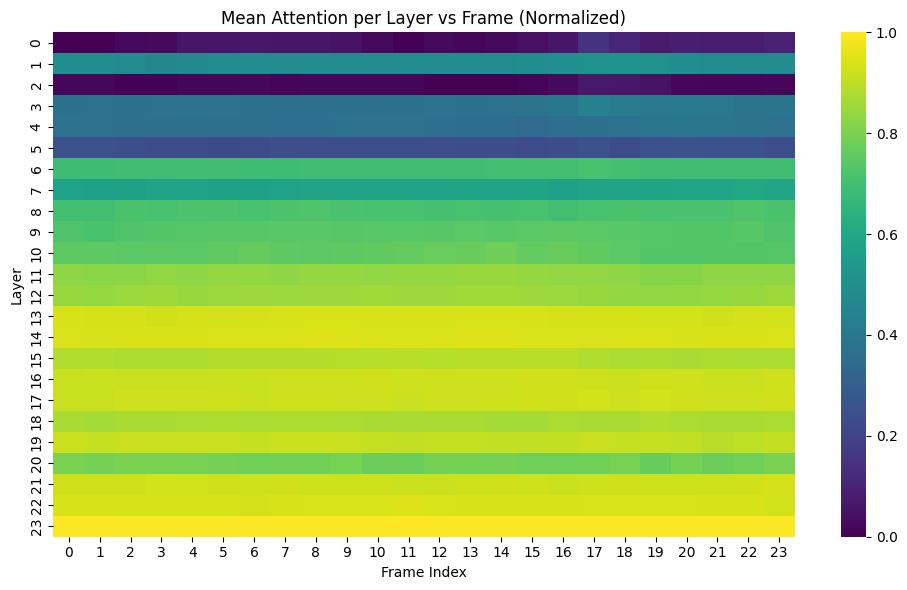

    Saved heatmap: attention_layer_llama/61179/original/layer_vs_frame_attention_Q1_original.png
  Plotting for Q2: Was the laptop open or closed at first?
Layer-frame matrix (normalized): [[0.       0.003801 0.02281  0.02472  0.05515  0.05515  0.05893  0.05704
  0.05704  0.04944  0.02661  0.007603 0.02472  0.0171   0.02661  0.03992
  0.05515  0.1445   0.10834  0.07227  0.0837   0.0817   0.0817   0.09125 ]
 [0.4905   0.4866   0.4734   0.4658   0.4695   0.481    0.481    0.4734
  0.479    0.4753   0.4753   0.4773   0.479    0.4773   0.479    0.4866
  0.4924   0.508    0.511    0.502    0.4905   0.481    0.4753   0.479   ]
 [0.01901  0.0171   0.007603 0.007603 0.015205 0.013306 0.0171   0.011406
  0.015205 0.013306 0.013306 0.013306 0.003801 0.003801 0.003801 0.011406
  0.02661  0.06274  0.06082  0.04752  0.01901  0.013306 0.013306 0.0171  ]
 [0.367    0.369    0.365    0.3706   0.3745   0.369    0.365    0.3613
  0.3613   0.367    0.3594   0.365    0.3706   0.367    0.3706   0.382
  0.3

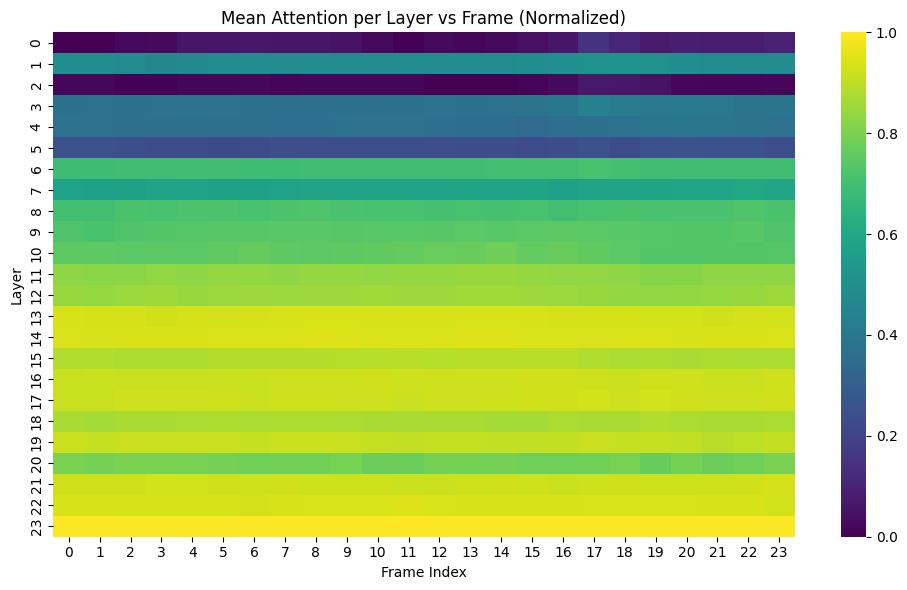

    Saved heatmap: attention_layer_llama/61179/original/layer_vs_frame_attention_Q2_original.png
  Plotting for Q3: When did the laptop start opening?
Layer-frame matrix (normalized): [[0.       0.003801 0.02281  0.02472  0.05515  0.05515  0.05893  0.05704
  0.05704  0.04944  0.02661  0.007603 0.02472  0.0171   0.02661  0.03992
  0.05515  0.1445   0.10834  0.07227  0.0837   0.0817   0.0817   0.09125 ]
 [0.4905   0.4866   0.4734   0.4658   0.4695   0.481    0.481    0.4734
  0.479    0.4753   0.4753   0.4773   0.479    0.4773   0.479    0.4866
  0.4924   0.508    0.511    0.502    0.4905   0.481    0.4753   0.479   ]
 [0.01901  0.0171   0.007603 0.007603 0.015205 0.013306 0.0171   0.011406
  0.015205 0.013306 0.013306 0.013306 0.003801 0.003801 0.003801 0.011406
  0.02661  0.06274  0.06082  0.04752  0.01901  0.013306 0.013306 0.0171  ]
 [0.367    0.369    0.365    0.3706   0.3745   0.369    0.365    0.3613
  0.3613   0.367    0.3594   0.365    0.3706   0.367    0.3706   0.382
  0.3936  

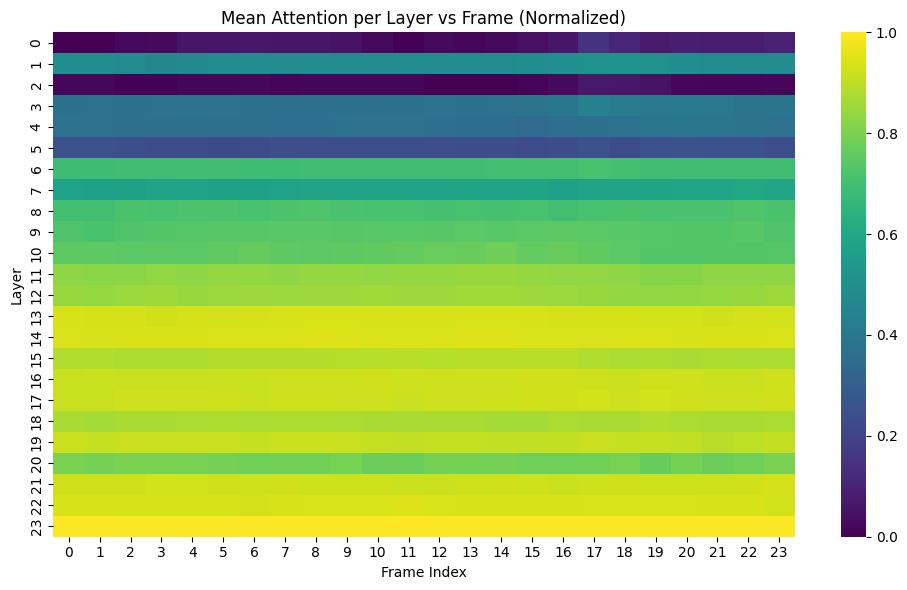

    Saved heatmap: attention_layer_llama/61179/original/layer_vs_frame_attention_Q3_original.png
  Plotting for Q4: Why does the hand lift the lid of the laptop?
Layer-frame matrix (normalized): [[0.       0.003801 0.02281  0.02472  0.05515  0.05515  0.05893  0.05704
  0.05704  0.04944  0.02661  0.007603 0.02472  0.0171   0.02661  0.03992
  0.05515  0.1445   0.10834  0.07227  0.0837   0.0817   0.0817   0.09125 ]
 [0.4905   0.4866   0.4734   0.4658   0.4695   0.481    0.481    0.4734
  0.479    0.4753   0.4753   0.4773   0.479    0.4773   0.479    0.4866
  0.4924   0.508    0.511    0.502    0.4905   0.481    0.4753   0.479   ]
 [0.01901  0.0171   0.007603 0.007603 0.015205 0.013306 0.0171   0.011406
  0.015205 0.013306 0.013306 0.013306 0.003801 0.003801 0.003801 0.011406
  0.02661  0.06274  0.06082  0.04752  0.01901  0.013306 0.013306 0.0171  ]
 [0.367    0.369    0.365    0.3706   0.3745   0.369    0.365    0.3613
  0.3613   0.367    0.3594   0.365    0.3706   0.367    0.3706   0.382

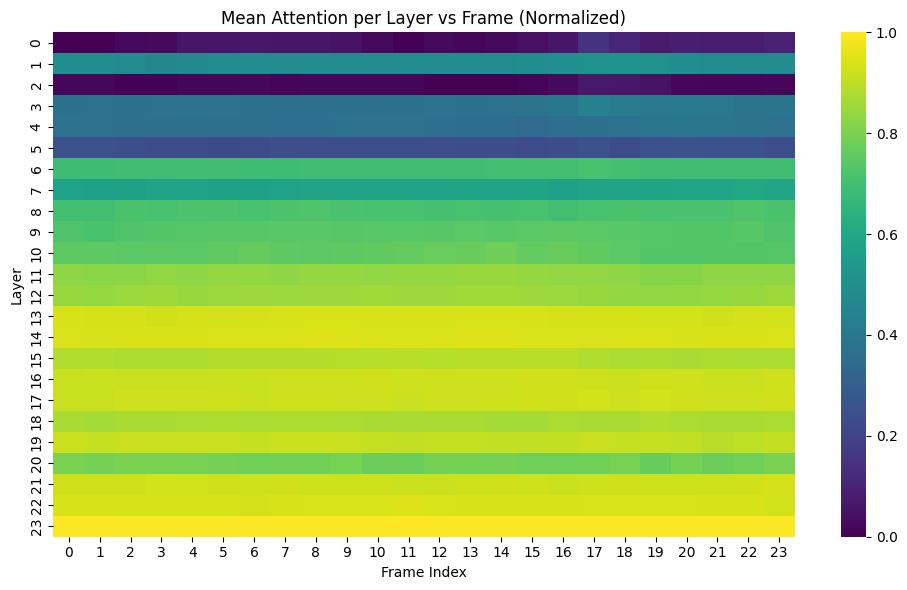

    Saved heatmap: attention_layer_llama/61179/original/layer_vs_frame_attention_Q4_original.png
  Plotting for Q5: Describe the sequence of actions."
Layer-frame matrix (normalized): [[0.       0.003801 0.02281  0.02472  0.05515  0.05515  0.05893  0.05704
  0.05704  0.04944  0.02661  0.007603 0.02472  0.0171   0.02661  0.03992
  0.05515  0.1445   0.10834  0.07227  0.0837   0.0817   0.0817   0.09125 ]
 [0.4905   0.4866   0.4734   0.4658   0.4695   0.481    0.481    0.4734
  0.479    0.4753   0.4753   0.4773   0.479    0.4773   0.479    0.4866
  0.4924   0.508    0.511    0.502    0.4905   0.481    0.4753   0.479   ]
 [0.01901  0.0171   0.007603 0.007603 0.015205 0.013306 0.0171   0.011406
  0.015205 0.013306 0.013306 0.013306 0.003801 0.003801 0.003801 0.011406
  0.02661  0.06274  0.06082  0.04752  0.01901  0.013306 0.013306 0.0171  ]
 [0.367    0.369    0.365    0.3706   0.3745   0.369    0.365    0.3613
  0.3613   0.367    0.3594   0.365    0.3706   0.367    0.3706   0.382
  0.3936  

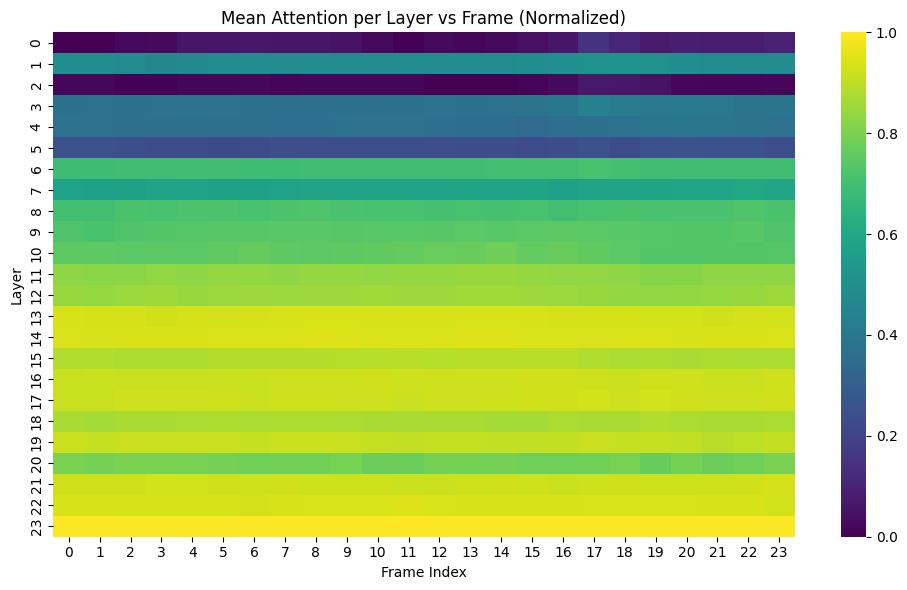

    Saved heatmap: attention_layer_llama/61179/original/layer_vs_frame_attention_Q5_original.png


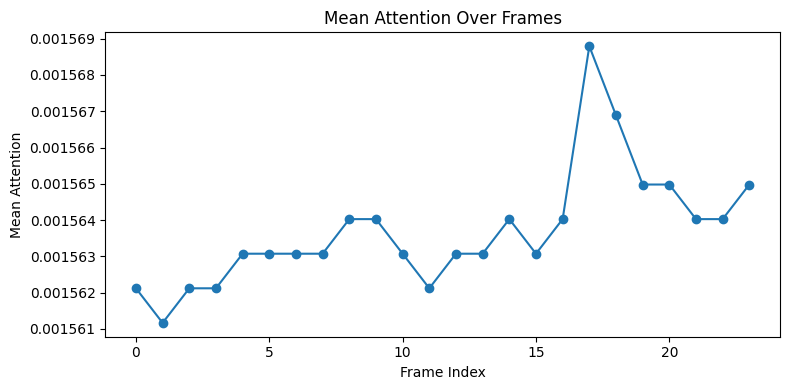

2025-09-16 22:58:28,800 - INFO - Starting analysis for /home/kassandralea.briola/Project/VideoCheck/61179.webm in mode crop-and-mask
2025-09-16 22:58:28,801 - INFO - Attempting to open video: /home/kassandralea.briola/Project/VideoCheck/61179.webm
2025-09-16 22:58:28,805 - INFO - Extracted 52 frames from /home/kassandralea.briola/Project/VideoCheck/61179.webm
2025-09-16 22:58:28,805 - INFO - Masks available from frame 0 to 207


    Saved mean attention plot: attention_layer_llama/61179/original/mean_attention_over_frames_original.png

--- Mode: crop-and-mask ---


2025-09-16 22:58:29,086 - INFO - Video 61179.webm: 24 frames, 12.0 fps
2025-09-16 22:58:29,086 - INFO - Mask statistics: {'total_frames': 24, 'frames_with_masks': 24, 'first_masked_frame': 0}
2025-09-16 22:58:29,124 - INFO - Preparing inputs for 61179 in mode crop-and-mask
2025-09-16 22:58:29,129 - INFO - Padded all crop-and-mask frames to shape (336, 336, 3)
2025-09-16 22:58:29,132 - INFO - Video tensor shape before processing: torch.Size([24, 3, 336, 336])
2025-09-16 22:58:32,450 - INFO - Generated response for 61179: 1. The hand is seen holding the laptop and then opening it. 2. The laptop is closed at first. 3. The...


  Extracting attention for 24 frames...
Frame 0 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 1 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 2 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 3 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 4 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 5 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 6 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 7 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 8 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 9 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 10 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 11 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 12 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 13 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 14 attention stack shape: torch.Size([24, 16, 577, 577])
Frame 15 attention stack 

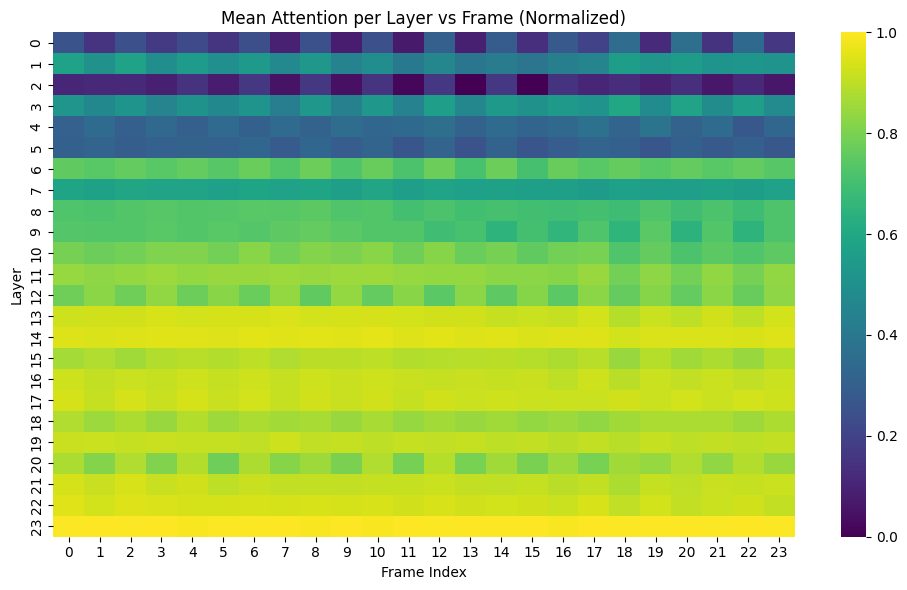

    Saved heatmap: attention_layer_llama/61179/crop-and-mask/layer_vs_frame_attention_Q1_crop-and-mask.png
  Plotting for Q2: Was the laptop open or closed at first?
Layer-frame matrix (normalized): [[0.2542   0.1488   0.2429   0.1658   0.226    0.1544   0.2411   0.0923
  0.2467   0.0753   0.2449   0.0697   0.2976   0.0866   0.288    0.1356
  0.275    0.1958   0.3503   0.11865  0.3616   0.145    0.3389   0.1562  ]
 [0.574    0.503    0.576    0.4878   0.546    0.4934   0.5425   0.469
  0.5347   0.4426   0.4878   0.4048   0.4614   0.3916   0.4143   0.388
  0.4275   0.4502   0.552    0.5195   0.548    0.516    0.5254   0.512   ]
 [0.10925  0.11676  0.11676  0.0866   0.1412   0.0791   0.16     0.0471
  0.1562   0.03955  0.1506   0.01695  0.1582   0.003767 0.16     0.
  0.145    0.10736  0.128    0.0923   0.1337   0.06213  0.113    0.06213 ]
 [0.5215   0.465    0.518    0.4502   0.5063   0.465    0.516    0.42
  0.5327   0.4312   0.5293   0.4426   0.5557   0.4634   0.5425   0.501
  0.5386 

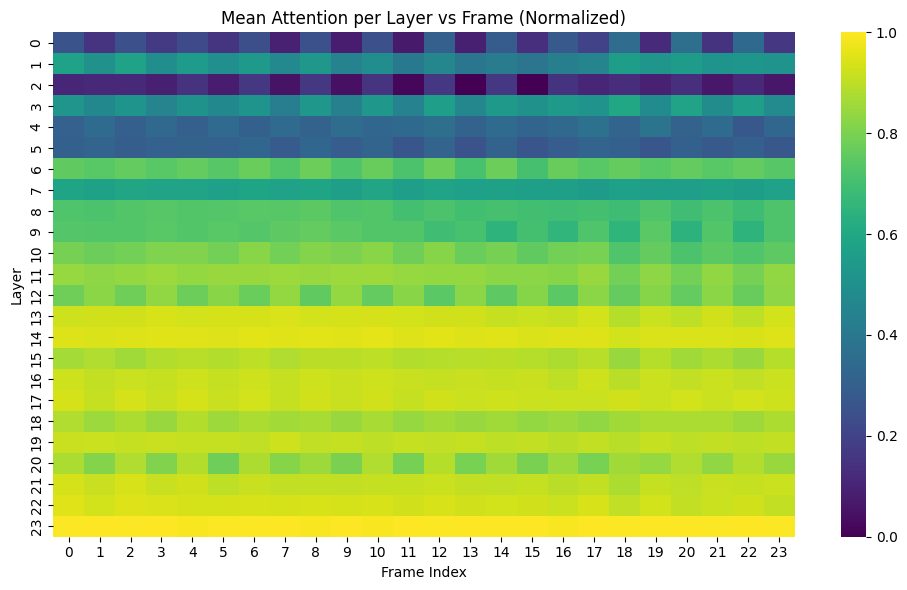

    Saved heatmap: attention_layer_llama/61179/crop-and-mask/layer_vs_frame_attention_Q2_crop-and-mask.png
  Plotting for Q3: When did the laptop start opening?
Layer-frame matrix (normalized): [[0.2542   0.1488   0.2429   0.1658   0.226    0.1544   0.2411   0.0923
  0.2467   0.0753   0.2449   0.0697   0.2976   0.0866   0.288    0.1356
  0.275    0.1958   0.3503   0.11865  0.3616   0.145    0.3389   0.1562  ]
 [0.574    0.503    0.576    0.4878   0.546    0.4934   0.5425   0.469
  0.5347   0.4426   0.4878   0.4048   0.4614   0.3916   0.4143   0.388
  0.4275   0.4502   0.552    0.5195   0.548    0.516    0.5254   0.512   ]
 [0.10925  0.11676  0.11676  0.0866   0.1412   0.0791   0.16     0.0471
  0.1562   0.03955  0.1506   0.01695  0.1582   0.003767 0.16     0.
  0.145    0.10736  0.128    0.0923   0.1337   0.06213  0.113    0.06213 ]
 [0.5215   0.465    0.518    0.4502   0.5063   0.465    0.516    0.42
  0.5327   0.4312   0.5293   0.4426   0.5557   0.4634   0.5425   0.501
  0.5386   0.5

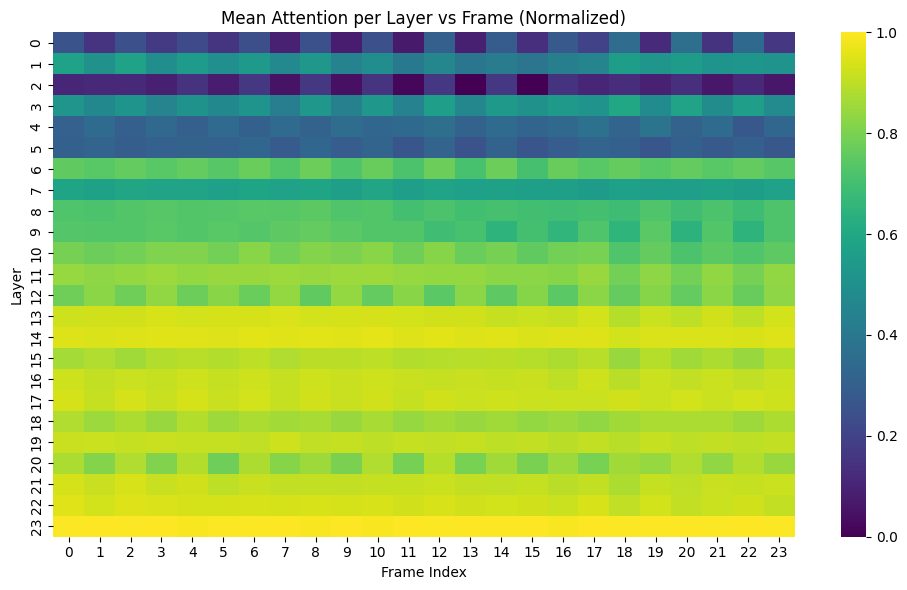

    Saved heatmap: attention_layer_llama/61179/crop-and-mask/layer_vs_frame_attention_Q3_crop-and-mask.png
  Plotting for Q4: Why does the hand lift the lid of the laptop?
Layer-frame matrix (normalized): [[0.2542   0.1488   0.2429   0.1658   0.226    0.1544   0.2411   0.0923
  0.2467   0.0753   0.2449   0.0697   0.2976   0.0866   0.288    0.1356
  0.275    0.1958   0.3503   0.11865  0.3616   0.145    0.3389   0.1562  ]
 [0.574    0.503    0.576    0.4878   0.546    0.4934   0.5425   0.469
  0.5347   0.4426   0.4878   0.4048   0.4614   0.3916   0.4143   0.388
  0.4275   0.4502   0.552    0.5195   0.548    0.516    0.5254   0.512   ]
 [0.10925  0.11676  0.11676  0.0866   0.1412   0.0791   0.16     0.0471
  0.1562   0.03955  0.1506   0.01695  0.1582   0.003767 0.16     0.
  0.145    0.10736  0.128    0.0923   0.1337   0.06213  0.113    0.06213 ]
 [0.5215   0.465    0.518    0.4502   0.5063   0.465    0.516    0.42
  0.5327   0.4312   0.5293   0.4426   0.5557   0.4634   0.5425   0.501
  0

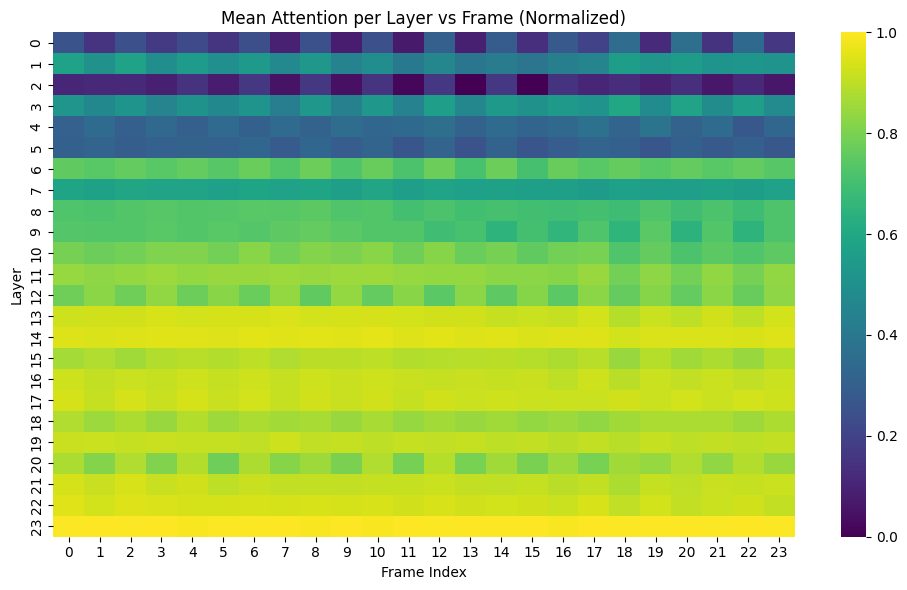

    Saved heatmap: attention_layer_llama/61179/crop-and-mask/layer_vs_frame_attention_Q4_crop-and-mask.png
  Plotting for Q5: Describe the sequence of actions."
Layer-frame matrix (normalized): [[0.2542   0.1488   0.2429   0.1658   0.226    0.1544   0.2411   0.0923
  0.2467   0.0753   0.2449   0.0697   0.2976   0.0866   0.288    0.1356
  0.275    0.1958   0.3503   0.11865  0.3616   0.145    0.3389   0.1562  ]
 [0.574    0.503    0.576    0.4878   0.546    0.4934   0.5425   0.469
  0.5347   0.4426   0.4878   0.4048   0.4614   0.3916   0.4143   0.388
  0.4275   0.4502   0.552    0.5195   0.548    0.516    0.5254   0.512   ]
 [0.10925  0.11676  0.11676  0.0866   0.1412   0.0791   0.16     0.0471
  0.1562   0.03955  0.1506   0.01695  0.1582   0.003767 0.16     0.
  0.145    0.10736  0.128    0.0923   0.1337   0.06213  0.113    0.06213 ]
 [0.5215   0.465    0.518    0.4502   0.5063   0.465    0.516    0.42
  0.5327   0.4312   0.5293   0.4426   0.5557   0.4634   0.5425   0.501
  0.5386   0.5

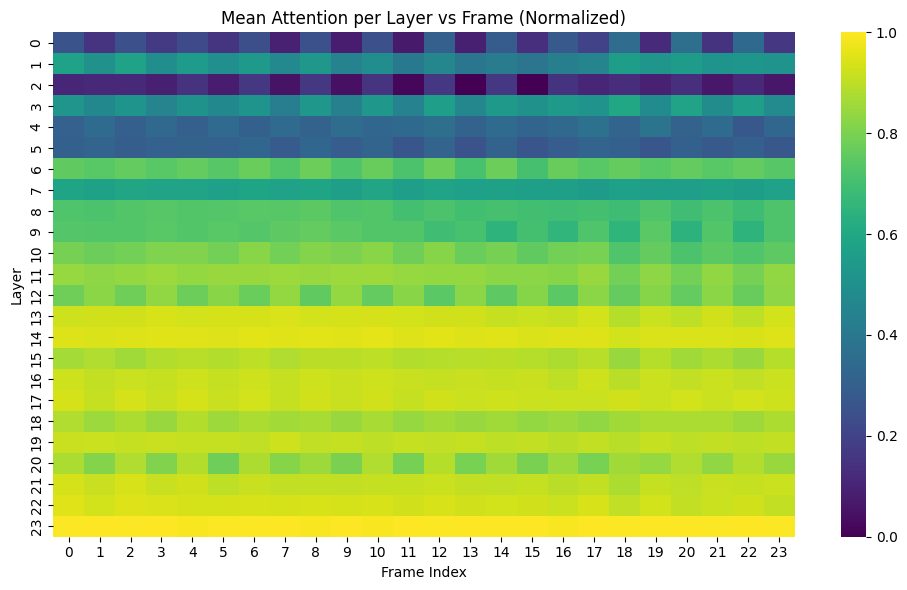

    Saved heatmap: attention_layer_llama/61179/crop-and-mask/layer_vs_frame_attention_Q5_crop-and-mask.png


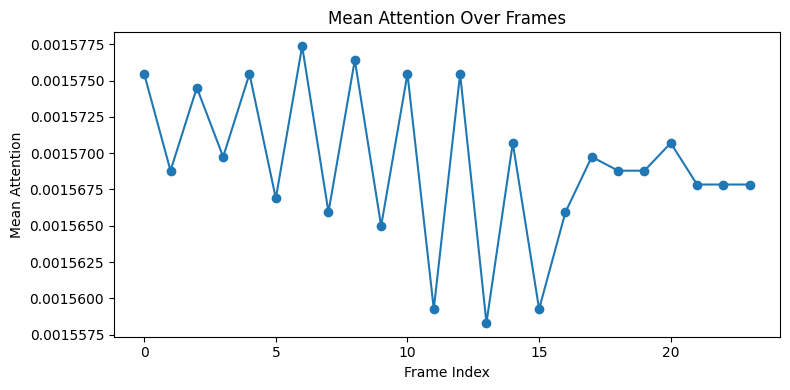

    Saved mean attention plot: attention_layer_llama/61179/crop-and-mask/mean_attention_over_frames_crop-and-mask.png


In [31]:
if __name__ == "__main__":
    try:
        torch.cuda.empty_cache()
        gc.collect()
        ModelLoader()
        interactive_analysis()
    except KeyboardInterrupt:
        print("\nProgram terminated by user.")
        sys.exit(0)